# 사전 작업

## 모듈 로드

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc

In [4]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', 400)

# 통합 데이터

In [57]:
def drop_features(data, keyword, debug=False):
    if debug:
        data = data[:1000]
        
    logits = []
    for col in data.columns:
        if keyword in col:
            logits.append(col)
        else:
            pass
    
    return logits

## 데이터 로드

In [51]:
path = './data/'

In [52]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

## 제거할 피처

In [63]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

# FEATS_EXCLUDED += drop_features(train, 'hist_duration')
# FEATS_EXCLUDED += drop_features(train, 'hist_amount_month_ratio')
# FEATS_EXCLUDED += drop_features(train, 'new_duration')
# FEATS_EXCLUDED += drop_features(train, 'new_amount_month_ratio')

FEATS_EXCLUDED += drop_features(train, 'hist_price')
FEATS_EXCLUDED += drop_features(train, 'new_price')

In [64]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [65]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65164	valid_1's rmse: 3.71639
[200]	training's rmse: 3.56694	valid_1's rmse: 3.68553
[300]	training's rmse: 3.51088	valid_1's rmse: 3.67429
[400]	training's rmse: 3.46854	valid_1's rmse: 3.66765
[500]	training's rmse: 3.43272	valid_1's rmse: 3.66397
[600]	training's rmse: 3.40279	valid_1's rmse: 3.66193
[700]	training's rmse: 3.37552	valid_1's rmse: 3.66045
[800]	training's rmse: 3.35106	valid_1's rmse: 3.66002
[900]	training's rmse: 3.32785	valid_1's rmse: 3.65936
[1000]	training's rmse: 3.30671	valid_1's rmse: 3.65828
[1100]	training's rmse: 3.28663	valid_1's rmse: 3.65774
[1200]	training's rmse: 3.26755	valid_1's rmse: 3.65795
[1300]	training's rmse: 3.24905	valid_1's rmse: 3.65808
Early stopping, best iteration is:
[1148]	training's rmse: 3.27725	valid_1's rmse: 3.65762
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.64991	valid_1's rmse:

KeyboardInterrupt: 

In [68]:
feature_importance[feature_importance.fold == 1].sort_values('importance')

,Feature,importance,fold
153,new_authorized_flag_mean,0,1
80,hist_purchase_year_mode,0,1
82,hist_purchase_year_mean,0,1
83,hist_purchase_year_max,0,1
84,hist_purchase_year_min,0,1
26,feature_min,0,1
261,hist_last_buy,0,1
202,new_purchase_year_min,0,1
201,new_purchase_year_max,0,1
144,hist_category_3_min_mean,0,1


# 이상치 없는 데이터

## 데이터 로드

In [5]:
path = './data/'

In [6]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

In [7]:
train = train[train.outliers == 0]

## 제거할 피처

In [8]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## Parameter

In [9]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

## training model

In [10]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60508	valid_1's rmse: 1.61676
[200]	training's rmse: 1.57258	valid_1's rmse: 1.58947
[300]	training's rmse: 1.5569	valid_1's rmse: 1.57843
[400]	training's rmse: 1.54652	valid_1's rmse: 1.57278
[500]	training's rmse: 1.53831	valid_1's rmse: 1.56901
[600]	training's rmse: 1.53133	valid_1's rmse: 1.56669
[700]	training's rmse: 1.52511	valid_1's rmse: 1.56515
[800]	training's rmse: 1.51955	valid_1's rmse: 1.56427
[900]	training's rmse: 1.51443	valid_1's rmse: 1.5636
[1000]	training's rmse: 1.50958	valid_1's rmse: 1.56307
[1100]	training's rmse: 1.50494	valid_1's rmse: 1.56258
[1200]	training's rmse: 1.50054	valid_1's rmse: 1.56232
[1300]	training's rmse: 1.49619	valid_1's rmse: 1.56206
[1400]	training's rmse: 1.492	valid_1's rmse: 1.5618
[1500]	training's rmse: 1.4879	valid_1's rmse: 1.56166
[1600]	training's rmse: 1.48388	valid_1's rmse: 1.56144
[1700]	training's rmse: 1.47992	valid_1's rmse:

In [15]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb

# 이상치 예측 모델

## 데이터 로드

In [16]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

In [17]:
target = train['outliers']

## 제거할 피처

In [18]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [19]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [20]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439393	valid_1's binary_logloss: 0.0466941
[200]	training's binary_logloss: 0.0439582	valid_1's binary_logloss: 0.0466935
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0439586	valid_1's binary_logloss: 0.0465615
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439916	valid_1's binary_logloss: 0.0471326
[200]	training's binary_logloss: 0.044006	valid_1's binary_logloss: 0.0471322
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0439602	valid_1's binary_logloss: 0.0470829
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0444197	valid_1's binary_logloss: 0.046345
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.046319
[300]	training's binary_logloss: 0.0443899	valid_1's binary_logloss: 0.0462997
[400]	tra

In [21]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb

# Combining

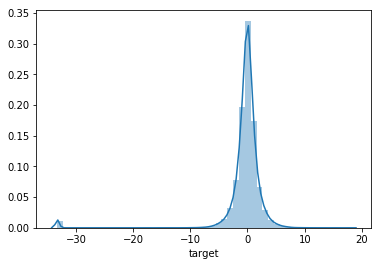

In [24]:
sns.distplot(train.target)

In [25]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(50000)['card_id'])

In [26]:
best_submission = pd.read_csv(path + 'submission_best_score.csv')

In [27]:
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [28]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [29]:
model_without_outliers.to_csv("./data/combining_submission.csv", index=False)